In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, MaxPooling2D, Conv2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pylab as pl

In [2]:
path_train = 'Training/'
train_dictionary = {"image_path":[],"target":[]}
type = 0
for i in os.listdir(path_train):
    train_img = path_train+i+'/'
    if(os.path.isdir(train_img)):
        for j in os.listdir(train_img):
            train_dictionary["image_path"].append(train_img+j)
            train_dictionary["target"].append(type)
        print(i, ":", type)
        type += 1
train = pd.DataFrame(train_dictionary)
train.info()

pituitary : 0
notumor : 1
glioma : 2
meningioma : 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5712 entries, 0 to 5711
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  5712 non-null   object
 1   target      5712 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.4+ KB


In [3]:
path_test = 'Testing/'
test_dictionary = {"image_path":[],"target":[]}
type = 0
for i in os.listdir(path_test):
    test_img = path_test+i+'/'
    if(os.path.isdir(test_img)):
        for j in os.listdir(test_img):
            test_dictionary["image_path"].append(test_img+j)
            test_dictionary["target"].append(type)
        print(i, ":", type)
        type += 1
test = pd.DataFrame(test_dictionary)
test.info()

pituitary : 0
notumor : 1
glioma : 2
meningioma : 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1311 non-null   object
 1   target      1311 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.6+ KB


In [4]:
with tf.device('/cpu:0'):
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.02, fill_mode='constant'),
        RandomContrast(0.1),
        RandomZoom(height_factor=0.01, width_factor=0.05),
        RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
    ])

Metal device set to: Apple M2


In [5]:
images = []
for i in train["image_path"]:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(168,168))
    img = np.expand_dims(img, axis=-1)
    img_aug = data_augmentation(img)
    img = img / 255.0
    img_aug = img_aug / 255.0
    images.append(img)
    images.append(img_aug)
label = []
label = train["target"]
x_train = np.array(images)
label = np.array(label)
label = np.repeat(label,2)
y_train = keras.utils.to_categorical(label, 4)
print(x_train.shape)
print(np.sum(y_train, axis=0))

(11424, 168, 168, 1)
[2914. 3190. 2642. 2678.]


In [6]:
images = []
for i in test["image_path"]:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(168,168))
    img = np.expand_dims(img, axis=-1)
    img = img / 255.0
    images.append(img)
label = []
label = test["target"]
x_test = np.array(images)
label = np.array(label)
y_test = keras.utils.to_categorical(label, 4)
print(x_test.shape)
print(np.sum(y_test, axis=0))

(1311, 168, 168, 1)
[300. 405. 300. 306.]


In [7]:
model = Sequential([
    Input(shape=(168,168,1)),
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.4),
    Dense(64, activation="relu"),
    Dropout(0.25),
    Dense(4, activation="softmax")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 164, 164, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)       

In [8]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True)
with tf.device('/gpu:0'):
    history = model.fit(
        x_train,
        y_train,
        batch_size = 32,
        epochs = 10,
        validation_data = (x_test, y_test),
        shuffle = True,
        callbacks = [reduce_lr, model_mc]
    )

Epoch 1/10
357/357 [==============================] - 37s 100ms/step - loss: 0.8013 - accuracy: 0.6641 - val_loss: 0.5592 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 2/10
357/357 [==============================] - 35s 97ms/step - loss: 0.3630 - accuracy: 0.8666 - val_loss: 0.4222 - val_accuracy: 0.8535 - lr: 0.0010
Epoch 3/10
357/357 [==============================] - 35s 97ms/step - loss: 0.2121 - accuracy: 0.9242 - val_loss: 0.2616 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 4/10
357/357 [==============================] - 35s 97ms/step - loss: 0.1406 - accuracy: 0.9519 - val_loss: 0.1747 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 5/10
357/357 [==============================] - 35s 97ms/step - loss: 0.0869 - accuracy: 0.9700 - val_loss: 0.1036 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 6/10
357/357 [==============================] - 39s 110ms/step - loss: 0.0614 - accuracy: 0.9793 - val_loss: 0.0938 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 7/10
357/357 [==============================] - 44

In [9]:
with tf.device('/cpu:0'):
    y_pred = model.predict(x_test)
y_pred2 = np.argmax(y_pred, axis=1)
print(y_pred2)
y_test = np.argmax(y_test, axis=1)
print(y_test)

41/41 [==============================] - 6s 136ms/step
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]


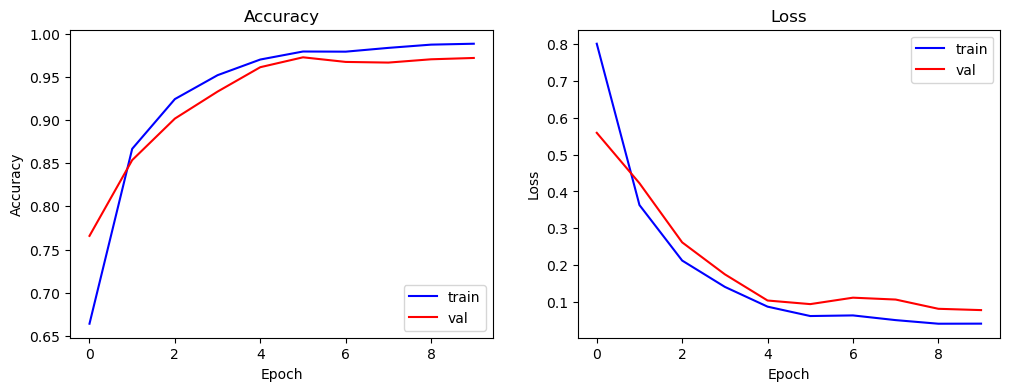

In [10]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

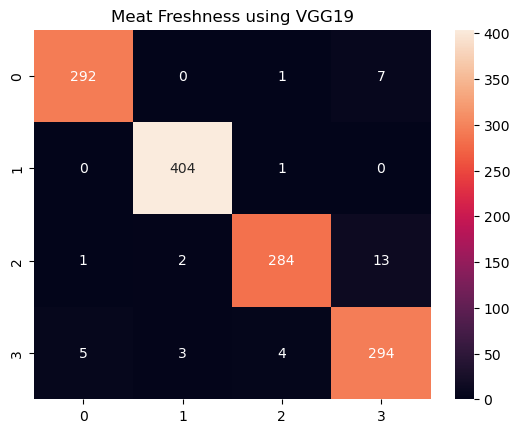

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       300
           1       0.99      1.00      0.99       405
           2       0.98      0.95      0.96       300
           3       0.94      0.96      0.95       306

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [11]:
confusion_matrix_result = confusion_matrix(y_test, y_pred2)
plt.title("Meat Freshness using VGG19")
ax = plt.subplot()
sns.heatmap(confusion_matrix_result, annot=True, fmt='g', ax=ax);
pl.show()
confusion_matrix = classification_report(y_test,y_pred2)
print(confusion_matrix)